In [1]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import altair as alt
from vega_datasets import data
import json
import numpy as np

Step 1: Scape data from Wikipedia

In [ ]:
ddd_requests = requests.get('https://en.wikipedia.org/wiki/List_of_Diners,_Drive-Ins_and_Dives_episodes')
ddd = BeautifulSoup(ddd_requests.text)

In [ ]:
# Get tables for 30 seasons
tables = ddd.find_all('table')

In [ ]:
def get_restaurants(s):
    """Given a season, return the featured restaurants as a dataframe."""
    
    season_dict = {'season': [],
                   'episode': [],
                   'title': [],
                   'restaurant': [],
                   'location': [],
                   'air_date': []
                  }
    
    if s == 22:
        restaurants = tables[s-1].find_all('tr')[1:-1]
    else:
        restaurants = tables[s-1].find_all('tr')[1:]
        
    index = 0

    while index < len(restaurants):
        
        # Get no. of restaurants visited in episode
        visited = int(restaurants[index].find('td').get('rowspan'))
        
        for i in range(visited):
            # Add season no.
            season_dict['season'].append(s)
            
            # Add episode no.
            episode_no = restaurants[index].find_all('td')[0].text
            season_dict['episode'].append(episode_no)
            
            # Add episode title
            title = restaurants[index].find_all('td')[1].text
            season_dict['title'].append(title)
            
            # Add air date
            air_date = restaurants[index].find_all('td')[-1].text
            season_dict['air_date'].append(air_date)
            
        # For first restaurant featured in episode
        # Add its name
        name_first = restaurants[index].find_all('td')[2].text
        season_dict['restaurant'].append(name_first)
        
        # Add its location
        location_first = restaurants[index].find_all('td')[3].text
        season_dict['location'].append(location_first)
        
        # For other restaurant(s) featured in episode
        for k in range(1, visited):
            # Add its name
            name_other = restaurants[index+k].find_all('td')[0].text
            season_dict['restaurant'].append(name_other)
            
            # Add its location
            # Address inconsistency in table for "The Memphis BBQ Tour"
            if (s == 3) & (index == 25):
                # Repeat location 3 times
                location_memphis = restaurants[index].find_all('td')[3].text
                season_dict['location'].append(location_memphis)
                
            else:    
                location_other = restaurants[index+k].find_all('td')[1].text
                season_dict['location'].append(location_other)
            
        index += visited
        
        time.sleep(.3)
    
    df = pd.DataFrame(season_dict)
    df = df.replace('\n', '', regex=True)
    df['air_date'] = df['air_date'].astype('datetime64[ns]')
    
    return df

In [ ]:
master = []
for i in range(30):
    df = get_restaurants(i+1)
    master.append(df)

In [ ]:
result = pd.concat(master)
result.head()

In [ ]:
result.to_csv(r'C:\Users\reiko\Desktop\flavortown\data\df_raw.csv', index=False, header=True)

In [ ]:
def get_restaurants_draft(s):
    """Given a season, return the featured restaurants as a dataframe."""
    
    season_dict = {'season': [],
                   'episode': [],
                   'title': [],
                   'restaurant': [],
                   'location': [],
                   'air_date': []
                  }
    
    if s == 22:
        episodes = tables[s-1].find_all('tr')[1:-1]
    else:
        episodes = tables[s-1].find_all('tr')[1:]
        
    index = 0

    while index < len(episodes):
        
        # Get no. of restaurants visited in episode
        visited = int(episodes[index].find('td').get('rowspan'))
        
        for i in range(visited):
            # Add season no.
            season_dict['season'].append(s)
            
            # Add episode no.
            episode_no = episodes[index].find_all('td')[0].text
            season_dict['episode'].append(episode_no)
            
            # Add episode title
            title = episodes[index].find_all('td')[1].text
            season_dict['title'].append(title)
            
            # Add air date
            air_date = episodes[index].find_all('td')[-1].text
            season_dict['air_date'].append(air_date)
            
        # For first restaurant featured in episode
        # Add its name
        name_first = episodes[index].find_all('td')[2].text
        season_dict['restaurant'].append(name_first)
        
        # Add its location
        location_first = episodes[index].find_all('td')[3].text
        season_dict['location'].append(location_first)
            
        # For other restaurant(s) featured in episode
        for k in range(1, visited):
            # Add its name
            name_other = episodes[index+k].find_all('td')[0].text
            season_dict['restaurant'].append(name_other)
        
            # Add its location
            location_other = episodes[index+k].find_all('td')[1].text
            season_dict['location'].append(location_other)
            
        index += visited
        
        time.sleep(.2)
    
    df = pd.DataFrame(season_dict)
    df = df.replace('\n', '', regex=True)
    df['air_date'] = df['air_date'].astype('datetime64[ns]')
    
    return df

In [ ]:
df = pd.read_csv('../data/df_raw.csv')

Step 2: Get latitudes and longitudes of restaurants

In [ ]:
geopy.geocoders.options.default_user_agent = 'my_app/1'
geopy.geocoders.options.default_timeout = 7

In [29]:
# Split dataframe
sub1 = df[:250]
sub2 = df[250:500]
sub3 = df[500:750]
sub4 = df[750:1000]
sub5 = df[1000:]

In [ ]:
def get_coordinates(df):
    "Given a list of locations, return latitudes and longitudes as series."
    latitude = []
    longitude = []
    
    for location in df['location']:
        geolocator = Nominatim()
        point = geolocator.geocode(location)
        latitude.append(point.latitude)
        longitude.append(point.longitude)
        print(location, point.latitude, point.longitude)
        
    return latitude, longitude

In [ ]:
lat1, long1 = get_coordinates(sub1)
sub1['latitude'] = lat1
sub1['longitude'] = long1

In [ ]:
lat2, long2 = get_coordinates(sub2)
sub2['latitude'] = lat2
sub2['longitude'] = long2

In [ ]:
lat3, long3 = get_coordinates(sub3)
sub3['latitude'] = lat3
sub3['longitude'] = long3

In [ ]:
# Change Carmel
sub3.replace('Carmel, California', 'Carmel-by-the-Sea, California')
# Change Dundalk
sub4.replace({'Dundalk, Colorado': 'Dundalk, Maryland', 
              'Carmel, California': 'Carmel-by-the-Sea, California'})

In [ ]:
lat4, long4 = get_coordinates(sub4)
sub4['latitude'] = lat4
sub4['longitude'] = long4

In [ ]:
lat5, long5 = get_coordinates(sub5)
sub5['latitude'] = lat5
sub5['longitude'] = long5

In [ ]:
df_coord = pd.concat([sub1, sub2, sub3, sub4, sub5])

In [ ]:
# Save dataframe with coordinates
df_coord.to_csv(r'C:\Users\reiko\Desktop\flavortown\data\df_coordinates.csv', index=False, header=True)

Step 3: Create dataframe for choropleth

In [267]:
df_coord = pd.read_csv('../data/df_coordinates.csv')

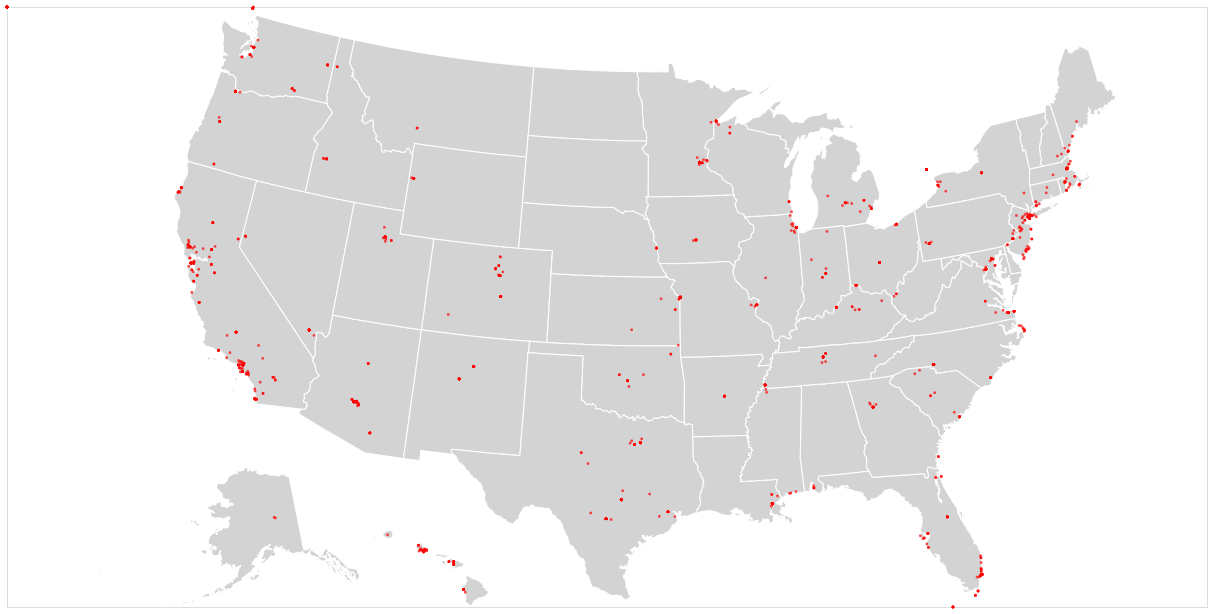

In [269]:
# Code attribution: https://altair-viz.github.io/gallery/airports.html

states = alt.topo_feature(data.us_10m.url, feature='states')

# US states background
background = (alt
              .Chart(states)
              .mark_geoshape(
                  fill='lightgray',
                  stroke='white'
              ).properties(
                  width=1200,
                  height=600
              ).project('albersUsa')
             )

restaurants = (alt
               .Chart(df_coord)
               .mark_circle(size=7, color='red')
               .encode(
                   longitude='longitude:Q',
                   latitude='latitude:Q',
                   tooltip=['season', 'episode', 'restaurant']
               ).project(
                   type='albersUsa'
               )
              )

background + restaurants

In [224]:
# Title case names
df_coord['restaurant'] = df_coord['restaurant'].str.title()

# Group restaurants by location
grouped = df_coord.groupby(['location', 'latitude', 'longitude'])['restaurant'].apply(set)

# Create dataframe for plotting
df_choro = pd.DataFrame(grouped).reset_index()

In [250]:
# Convert set to list to str for restaurant column
results = []
for i in range(len(df_choro)):
    places_list = [place for place in df_choro['restaurant'][i]]
    places_str = ", ".join(places_list)
    results.append(places_str)

In [258]:
# Reassign and rename restaurant column
df_choro['restaurant'] = results
df_choro = df_choro.replace("'S", "'s", regex=True)

df_choro = df_choro.rename(columns={'restaurant': 'place(s) visited'})

In [261]:
df_choro.head()

,location,latitude,longitude,place(s) visited
0,"Adkins, Texas",29.393013,-98.237233,Texas Pride Bbq
1,"Aiea, Hawaii",21.382222,-157.933611,The Alley Restaurant At Aiea Bowl
2,"Alameda, California",37.609029,-121.899142,Scolari's Good Eats
3,"Albuquerque, New Mexico",35.084103,-106.650985,"Bocadillos, The Cube, Torinos, Golden Crown Re..."
4,"Allston, Massachusetts",42.355434,-71.132127,"Lone Star Taco Bar, Deep Ellum"


In [262]:
df_choro.to_csv(r'C:\Users\reiko\Desktop\flavortown\data\df_choropleth.csv', index=False, header=True)

In [270]:
# Plot choropleth
cities = (alt
          .Chart(df_choro)
          .mark_circle(size=7, color='red')
          .encode(
              longitude='longitude:Q',
              latitude='latitude:Q',
              tooltip=['location', 'place(s) visited']
          ).project(
              type='albersUsa'
          )
         )

plot = background + cities

In [271]:
plot.save('../flavortown-test.html')

Step 4: Use Yelp API to add rating and price range for each establishment

In [160]:
df = pd.read_csv('../data/df_raw.csv')

In [162]:
df['restaurant'] = (df['restaurant']
                    .replace({"&": "",
                              "!": "",
                              "'": "",
                              "-": " "},
                             regex=True)
                   )

In [3]:
# Followed tutorial at https://python.gotrained.com/yelp-fusion-api-tutorial/ 
api_key = 'pITuoqCz9RcQv_u7xJDZFz19f6jYJAgvNeWJrkcVG2Ux9GCAKFryDc7FfS7YL823Cbi269KaQGygRkvukbyeurZOSYhek5xyYfQCHdFDcGKR5CpzhhR62BRwriGKXnYx'
headers = {'Authorization': 'Bearer %s' % api_key}

In [15]:
# Code attribution: https://www.datacamp.com/community/tutorials/fuzzy-string-python

def levenshtein_ratio(s, t, ratio_calc = True):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [112]:
url = 'https://api.yelp.com/v3/businesses/search'

def get_business_info(df, alpha=0.7):
    "Add Yelp URL for each business. Alpha denotes strictness of fuzzy string matching."
    name_list = []
    rating_list = []
    price_list = []
    
    for i in range(df.shape[0]):
        params = {'term': df['restaurant'].iloc[i], 'location': df['location'].iloc[i]}
        req = requests.get(url, params=params, headers=headers)
        parsed = json.loads(req.text)
        
        try:
            if (len(parsed['businesses']) != 0 and
                levenshtein_ratio(df['restaurant'].iloc[i].lower(), parsed['businesses'][0]['name'].lower()) > alpha):
                try:
                    business_rating = parsed['businesses'][0]['rating']
                    rating_list.append(business_rating)
                except:
                    rating_list.append(None)
                try:
                    business_price = parsed['businesses'][0]['price']
                    price_list.append(business_price)
                except:
                    price_list.append(None)
            else:
                rating_list.append(None)
                price_list.append(None)
        except:
            rating_list.append(None)
            price_list.append(None)
    
    df['rating'] = rating_list
    df['price'] = price_list
    
    return df

In [ ]:
sub1_yelp = get_business_info(df.iloc[0:500])

In [ ]:
sub2_yelp = get_business_info(df.iloc[250:500])

In [ ]:
sub3_yelp = get_business_info(df.iloc[500:750])

In [ ]:
sub4_yelp = get_business_info(df.iloc[750:1000])

In [ ]:
sub5_yelp = get_business_info(df.iloc[1000:])

In [175]:
df_yelp = pd.concat([sub1_yelp, sub2_yelp, sub3_yelp, sub4_yelp, sub5_yelp])

In [176]:
location = df_yelp['location'].str.split(',', n=1, expand=True)
df_yelp['city'] = location[0]
df_yelp['state'] = location[1]
df_yelp = df_yelp.drop(['air_date', 'location'], axis=1)

In [184]:
df_yelp

,season,episode,title,restaurant,rating,price,city,state
0,1,1,Classics,Mac & Ernie's Roadside Eatery,4.0,$$,Tarpley,Texas
1,1,1,Classics,Brint's Diner,3.5,$,Wichita,Kansas
2,1,1,Classics,The Mad Greek Cafe,3.0,$$,Baker,California
3,1,2,That's Italian,Pizza Palace,4.0,$,Knoxville,Tennessee
4,1,2,That's Italian,Hullabaloo Diner,3.5,$$,Wellborn,Texas
...,...,...,...,...,...,...,...,...
1246,30,1,A World of Barbecue,Grand Ole BBQ,4.5,$$,San Diego,California
1247,30,1,A World of Barbecue,Locale BBQ Post,4.0,$$,Wilmington,Delaware
1248,30,2,"Sausage, Shawarma and Scaloppini",Tahini,4.5,$,San Diego,California
1249,30,2,"Sausage, Shawarma and Scaloppini",Corduroy Pie Co.,4.5,$$,Vancouver,British Columbia


In [3]:
df_yelp = pd.read_csv('../data/df_yelp.csv')

In [ ]:
# Identify problematic entries
df_yelp[df_yelp['state'].isnull()]

In [50]:
df_yelp.at[240, 'state'] = 'Oklahoma'
df_yelp.at[339, 'state'] = 'DC'
df_yelp.at[358, 'state'] = 'DC'
df_yelp.at[368, 'state'] = 'DC'
df_yelp.at[393, 'state'] = 'DC'
df_yelp.at[917, 'state'] = 'New Jersey'
df_yelp.at[925, 'state'] = 'Florida'
df_yelp.at[908, 'state'] = 'UK'

In [51]:
df_yelp['state'].unique()

array([' Texas', ' Kansas', ' California', ' Tennessee', ' Nevada',
       ' Illinois', ' North Carolina', ' Wisconsin', ' New York',
       ' Oklahoma', ' Maine', ' Indiana', ' New Hampshire', ' Washington',
       ' Oregon', ' South Carolina', ' Massachusetts', ' New Jersey',
       ' Michigan', ' Minnesota', ' Pennsylvania', ' Rhode Island',
       ' Florida', ' Missouri', ' Arizona', ' Kentucky', ' New Mexico',
       ' Virginia', ' Colorado', ' Georgia', ' West Virginia', ' Alabama',
       ' Maryland', ' Louisiana', ' Mississippi', ' Utah', ' Nebraska',
       ' Connecticut', ' Idaho', 'Oklahoma', ' Ohio', ' Hawaii', 'DC',
       ' British Columbia', ' Ontario, Canada', ' Mexico', ' Ontario',
       ' Wyoming', ' Iowa', ' Italy', ' UK', 'UK', ' DC', 'New Jersey',
       'Florida', ' Alaska', ' Cuba', ' Spain', ' Montana', ' Arkansas',
       ' Delaware'], dtype=object)

In [55]:
df_yelp['state'] = df_yelp['state'].str.strip()

In [65]:
df_yelp.to_csv(r'C:\Users\reiko\Desktop\flavortown\data\df_yelp.csv', index=False, header=True)